# Initialization

## library install

In [1]:
!pip install networkx
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install zipfile

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


## Imports

In [2]:
import zipfile
import numpy as np
import pandas as pd
import pickle as pk
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

np.random.seed(42)

## Data
Data download and decompression

In [3]:
!curl https://frasca.di.unimi.it/MLDNN/input_data.zip -O data.zip # cambiare in wget quando passiamo a Colab 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 59 4581k   59 2710k    0     0  1122k      0  0:00:04  0:00:02  0:00:02 1123k
100 4581k  100 4581k    0     0  1597k      0  0:00:02  0:00:02 --:--:-- 1598k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: data.zip
curl: (3) URL rejected: No host part in the URL
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload

In [4]:
with zipfile.ZipFile("input_data.zip", 'r') as zip_ref: #data.zip file name quando passiamo a Colab
     zip_ref.extractall("unzipped_data")


with open("unzipped_data/input_data.pkl", "rb") as f:
     data_dict = pk.load(f)

Storing

In [5]:
W = data_dict['similarity_matrix']
labels = data_dict['labels']
true_labels = data_dict['true_labels']

# 1-3) Hopfield Network Model
For our task, the most appropriate model is an Hopfield Network, since we can use its minimization of the energy function to construct a pattern where similar nodes will have the same label. 
We are using the Hopfield Network as a Local Optimizator.

It is a suitable choice as our labels (targets) are in {-1, 1} which is perfect for our Hopfield Network.

The network optimization algorithm will reiterate until it will reach an equilibruim state, which corresponds to the reach of a minimum of the energy function. This minimum will be reached once all unlabelled nodes will have a label and similar nodes will have the same one.

The nodes with a {0} label are the ones for which the true label is unknown, the ones that have to be predicted.

The next cell draws a draft of an hopfield network, the purpose is to give a graphical representation of the starting state.

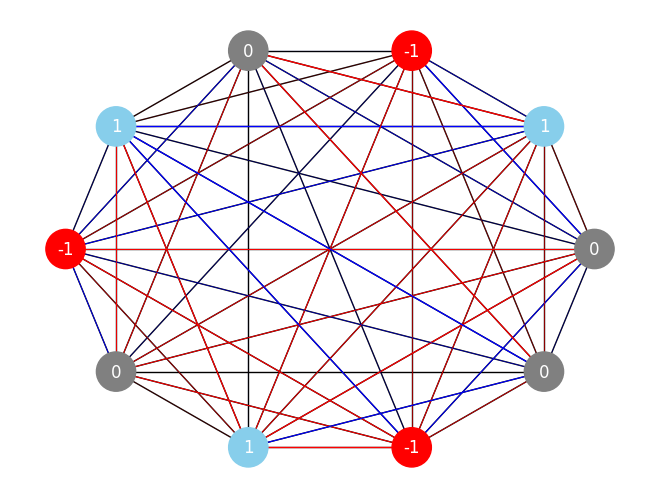

In [6]:
# Number of nodes to draw
N = 10  

# Node labels (and colors)
ex_labels = {i: str(v) for i, v in enumerate([0, 1, -1, 0, 1, -1, 0, 1, -1, 0])}
ex_colors = ["gray" if v == 0 else "skyblue" if v == 1 else "red" for v in [0, 1, -1, 0, 1, -1, 0, 1, -1, 0]]

# Create a fully connected graph
G = nx.complete_graph(N)

# assign random weights for representation purposes
for (i, j) in G.edges():
    G[i][j]['weight'] = np.random.uniform(-1, 1)  # sample from a uniform distribution

# assign weights
weights = [G[i][j]['weight'] for i, j in G.edges()]

# Normalize colors
edge_colors = ['red' if w < 0 else 'blue' for w in weights] # red if < 0 and blue otherwise
edge_widths = [abs(w)*1 for w in weights]  # width independent from the weight, I didn't like it

# Circular layout for nodes
pos = nx.circular_layout(G)

# Plot
nx.draw(G, pos, 
        with_labels=True, 
        labels=ex_labels, 
        node_color=ex_colors, 
        node_size=800, 
        font_color="white")

nx.draw_networkx_edges(G, pos, 
                       edge_color=edge_colors, 
                       width=edge_widths)

plt.show()



The Hopfield Network is a recurrent network with stable states, which iterates until an equilibrium state is reached.<br>
An equilibrium state consists of the reach of a minimum of the energy function.
$$
E(x) = -\frac{1}{2} \sum_{i \neq j} w_{ij} x_i x_j
$$
The aim of the model is to minimize this function and by setting the labels of unknown nodes ({0} labels) the same as those of similar nodes.<br>

Can be done thanks to Hebbian Learning Rule:
$$
w_{ij} = \frac{1}{N} \sum_{\mu=1}^{P} \xi_i^\mu \, \xi_j^\mu, \quad w_{ii} = 0
$$
which lets us set higher weights between similar nodes.<br>

In our case, since all weights are already set and we wont't change them, we can exploit it to derive node labels based off the incoming weights of each node.<br>

From this we can derive the formula to update every neuron, this is done asynchronously.
$$
x_i(t+1) = \text{sign}\!\left(\sum_{j=1}^N w_{ij} \, x_j(t) \right)
$$

Equivalently we can use it as a treshold activation function where the state of the node is determined by the value of the activation function, with treshold set to 0.<br>

Where the activation function is expressed as:
$$
h_i(t) = \sum_{j=1}^N w_{ij} \, x_j(t)
$$

And the activation of the neuron is based off the system:
$$
x_i(t+1) =
\begin{cases}
+1 & \text{if } h_i(t) > 0, \\
-1 & \text{if } h_i(t) \leq 0.
\end{cases}
$$


### Implementation
The next cell actually implement the Hopfield Network as a local optimizer

In [7]:
# Hopfield network as local optimizer
class HopfieldNetworkLO:
    def __init__(self, weight_matrix):
        """Initialize network with a given weight matrix."""
        self.W = np.array(weight_matrix)  # Convert weight matrix to numpy array
        self.N = self.W.shape[0]  # Number of neurons

    def run_dynamics(self, labels, max_iterations=100):
        """Perform asynchronous updates for neurons labeled as '0'."""
        state = np.array(labels, dtype=int)  # Convert labels to float array
        free_neurons = np.where(state == 0)[0]  # Indices of neurons to update
        fixed_neurons = np.where(state != 0)[0]  # Indices of fixed neurons

        # Compute external influence from fixed neurons
        b = np.dot(self.W[:, fixed_neurons], state[fixed_neurons])  # Activation threshold

        for _ in range(max_iterations):
            updated = False
            for i in free_neurons:
                # Compute total input sum (including fixed neurons' influence)
                activation = np.dot(self.W[i], state) - b[i]
                new_state = 1 if activation > 0 else -1

                if new_state != state[i]:
                    state[i] = new_state
                    updated = True

            if not updated:  # Stop if no changes occur
                break

        return state

we save the result of the local optimization for further analysis

In [8]:
outcome = HopfieldNetworkLO(W).run_dynamics(labels)

# 2) INPUT
<p>Each author will be represented by a node, which value is going to be its label (labels), while the edges will be represented by the author similarity matrix (W).</p>
<p>This method will result in a fully connected network with n=5000 nodes, there could be some kind of non-existing nodes as their weight might be 0.</p>
<p>The node labels with a value different from {0} won't to be updated.</p>
<p>Other than the initial state the network doesn't need any other input to work.</p>

The next cell plot the initial state of the Network aside of the final one, with the purpose to show the effective evolution of the nodes.<br>

All of the nodes that in the intial state were gray (label = 0) eventually become either orange (label = -1) or blue (label = 1)

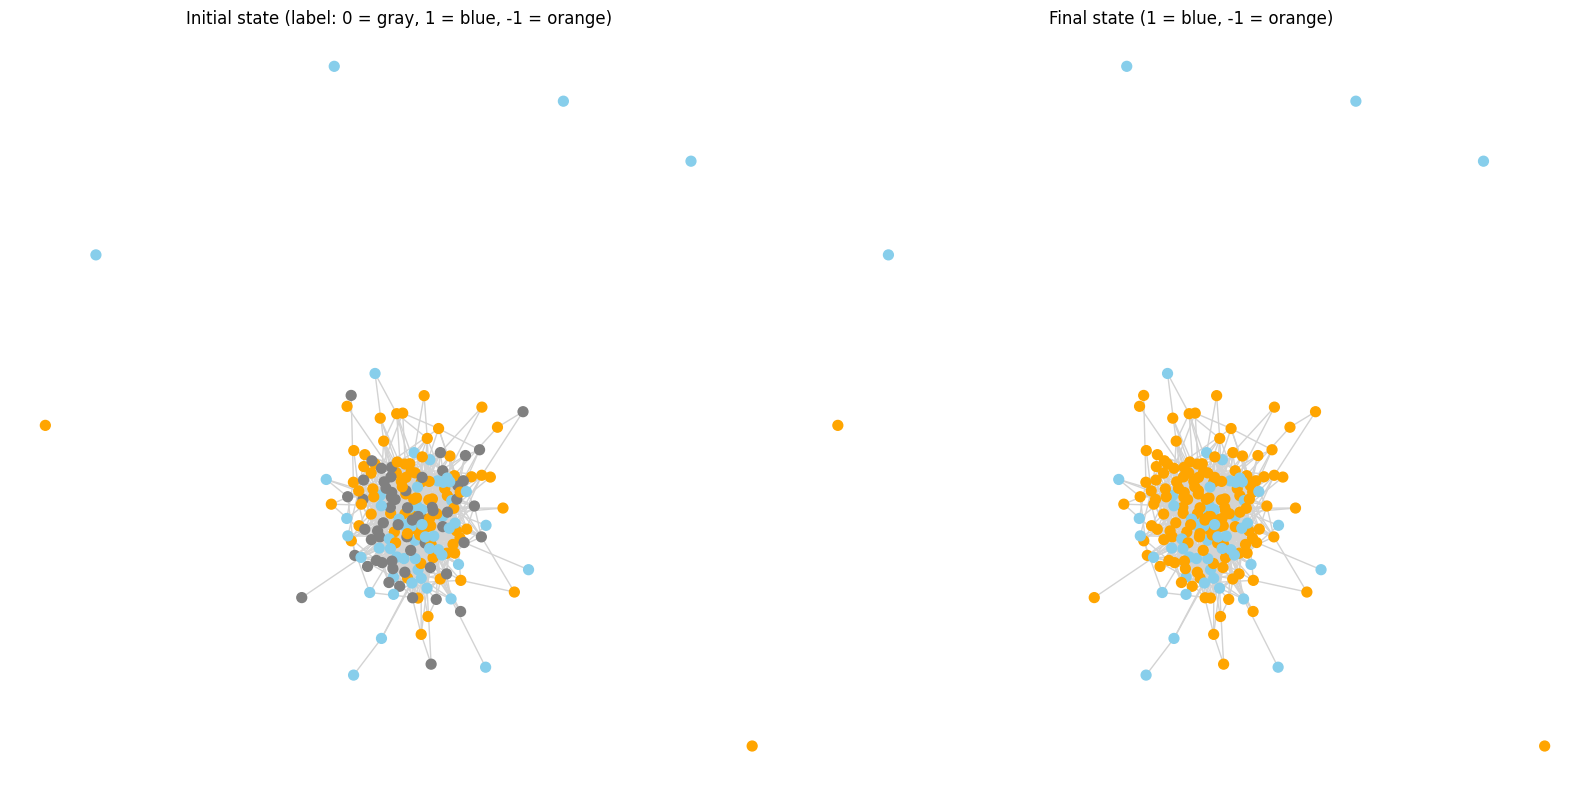

In [9]:
# --- RIGHE ORIGINALI COMMENTATE ---
# indices = np.arange(len(labels))
# selected = np.sort(indices)
# W_sub = W[np.ix_(selected, selected)]
# labels_sub = labels[selected]
# outcome_sub = outcome[selected]
# --- NUOVA SELEZIONE DI SOTTOINSIEME DI NODI ---
max_nodes = 200
unlabelled_mask = (labels == 0)
unlabelled_indices = np.where(unlabelled_mask)[0]
labelled_indices = np.where(~unlabelled_mask)[0]
min_unlabelled = int(0.3 * max_nodes)
num_unlabelled = min(len(unlabelled_indices), min_unlabelled)
num_labelled = max_nodes - num_unlabelled
selected_unlabelled = np.random.choice(unlabelled_indices, num_unlabelled, replace=False)
selected_labelled = np.random.choice(labelled_indices, num_labelled, replace=False)
selected = np.sort(np.concatenate([selected_unlabelled, selected_labelled]))
W_sub = W.iloc[selected, selected] if hasattr(W, 'iloc') else np.array(W)[np.ix_(selected, selected)]
labels_sub = labels[selected]
outcome_sub = outcome[selected]
# fino a qua
G = nx.from_numpy_array(np.array(W_sub)) 
pos = nx.spring_layout(G, seed=42) # position is seeded so that the initial and final state have the same shape, nodes can be more easily identified
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# Plot the initial state
node_colors_init = ['gray' if l==0 else ('skyblue' if l==1 else 'orange') for l in labels_sub]
nx.draw(G, pos, ax=axs[0], with_labels=False, node_color=node_colors_init, edge_color='lightgray', node_size=50)
axs[0].set_title('Initial state (label: 0 = gray, 1 = blue, -1 = orange)')
# Plot the final state
node_colors_out = [('gray' if outcome_sub[i]==0 else ('skyblue' if outcome_sub[i]==1 else 'orange')) for i in range(len(selected))]
nx.draw(G, pos, ax=axs[1], with_labels=False, node_color=node_colors_out, edge_color='lightgray', node_size=50)
axs[1].set_title('Final state (1 = blue, -1 = orange)')
plt.tight_layout()
plt.show()

<p>In the plot there may be some "missing" edges between nodes.<br>
They are not missing as the Hopfield Network works as a fully connected graph with synnetric edges.<br> 
Those nodes are not represented, as their weight in the author simlarity matrix is 0. <br>
NetworkX assumes, as their weight is 0, that they are not there but the model itself uses them.

# 4) Model evaluation
The performance of the model may be asserted usign accuracy (or F1 as classes may be slightly unblanaced) 
#### CHANGE
Even though our task is a binary classification task we cannot use Binary Cross Entropy, since it expect probabilities as prediction, while our is a hard prediction. BCE uses logarithms for predicted values, the log value of 0 or -1 is not defined and it may lead to unpredicted behaviour.

In [10]:
accuracy = np.mean(outcome == true_labels)
print(f"Accuratezza: {accuracy * 100:.2f}%")
score = f1_score(outcome, true_labels)
print(f'F1 score = {score * 100:.2f}%')


Accuratezza: 93.30%
F1 score = 91.90%


In [11]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming W is your similarity matrix, labels are initial labels, and inferred_state contains the inferred labels

# # Check if inferred_state is available
# if 'outcome' not in locals():
#     print("Error: 'inferred_state' not found. Please run the Hopfield network dynamics first.")
# else:
#     # Create a graph from the weight matrix W
#     G = nx.from_numpy_array(W)

#     # Define a color map for the labels (-1, 0, 1)
#     color_map = {-1: 'red', 0: 'gray', 1: 'blue'}

#     # Map the initial labels to colors
#     initial_colors = [color_map.get(label, 'gray') for label in labels]

#     # Map the inferred states to colors
#     inferred_colors = [color_map.get(label, 'gray') for label in outcome] # Use gray for any unexpected labels

#     # Select a subset of nodes for visualization if the graph is too large
#     nodes_to_draw = G
#     initial_colors_to_draw = initial_colors
#     inferred_colors_to_draw = inferred_colors

#     # Draw the graphs side by side
#     fig, axes = plt.subplots(1, 2, figsize=(24, 10)) # Adjust figure size as needed

#     # Plot for Initial State
#     nx.draw(nodes_to_draw, ax=axes[0], node_color=initial_colors_to_draw, with_labels=False, node_size=50)
#     axes[0].set_title("Initial State (Original Labels)")

#     # Plot for Inferred State
#     nx.draw(nodes_to_draw, ax=axes[1], node_color=inferred_colors_to_draw, with_labels=False, node_size=50)
#     axes[1].set_title("Inferred State")

#     plt.tight_layout()
#     plt.show()